# Mounting to Drive
The following mounts to Google Drive and changes directory into the relevant directory for the purposes of this Demo (assumes that the directory has a shortcut in My Drive!)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "drive/Shareddrives/DeepBio"
%ls

# Running Things


In [ ]:
import numpy as np
from scipy.sparse import load_npz, find
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, Flatten, Dense, MaxPooling1D, Reshape, Conv2DTranspose
import tensorflow_probability as tfp

## Data Preprocessing

In [ ]:
base_path = "/content/drive/MyDrive/GC Merge Data/data"
cell_line = "E116"
regression_flag = 0
chip_res = 10000
hic_res = 10000
num_hm = 5
num_feat = int((hic_res/chip_res)*num_hm)
slice_len = 256

# Downsampling Hi-C

In [ ]:
def downsample_sparse_hic_matrix(sparse_matrix, downsample_factor):
    # Generate random scaling factors for each read, ensuring a different factor for each
    random_factors = tf.random.uniform(tf.shape(sparse_matrix.values), 0, downsample_factor, dtype=tf.dtypes.double)

    # Apply downsampling
    downsampled_values = sparse_matrix.values * random_factors
    downsampled_sparse_tensor = tf.SparseTensor(indices=sparse_matrix.indices, values=downsampled_values, dense_shape=sparse_matrix.dense_shape)

    # Normalize the downsampling to ensure the total reads is approximately 1/16th of the original
    total_reads_original = tf.reduce_sum(sparse_matrix.values)
    total_reads_downsampled = tf.reduce_sum(downsampled_sparse_tensor.values)
    adjustment_factor = (total_reads_original / 16) / total_reads_downsampled
    adjusted_values = downsampled_sparse_tensor.values * adjustment_factor
    adjusted_downsampled_sparse_tensor = tf.SparseTensor(indices=sparse_matrix.indices, values=adjusted_values, dense_shape=sparse_matrix.dense_shape)

    return adjusted_downsampled_sparse_tensor

### One Chromosome at a Time

In [ ]:
chr_num = 1
folder = f"{base_path}/{cell_line}/{hic_res}/chr{chr_num}"
hic_sparse_mat_file = f"{folder}/hic_sparse_redone_h3k27ac_addition.npz"

np_hmods_norm_all_file = f"{folder}/np_hmods_norm_chip_{chip_res}bp_redone_h3k27ac_addition.npy"

mat = load_npz(hic_sparse_mat_file)
rows, cols, values = find(mat)
indices = np.column_stack((rows,cols))
shape = [np.max(indices[:,0]) + 1, np.max(indices[:,1]) + 1]  # Assuming 0-based indexing
mat = tf.SparseTensor(indices=indices, values=values, dense_shape=shape)

down_mat = downsample_sparse_hic_matrix(mat, downsample_factor = 1/16)

hms = np.load(np_hmods_norm_all_file)
hms = hms[:, 1:] #only includes features, not node ids
hms = tf.convert_to_tensor(hms.reshape(-1, num_feat), dtype=tf.float32)

In [ ]:
def get_next_sample(slice_len):
  num_bins = len(hms)
  diag_ind = 0
  for i in range(0, (num_bins // slice_len) -1):
    hms_sub = hms[i*slice_len: (i+1) * slice_len]
    for j in range(i, (num_bins // slice_len) -1):
      hi_hic_sub = tf.sparse.to_dense(tf.sparse.slice(mat, start=(i,j), size=(slice_len, slice_len)))
      lo_hic_sub = tf.sparse.to_dense(tf.sparse.slice(down_mat, start=(i,j), size=(slice_len, slice_len)))
      yield lo_hic_sub, hi_hic_sub, hms_sub

dataset = tf.data.Dataset.from_generator(
    get_next_sample,
    output_signature=(
        tf.TensorSpec(shape=(slice_len,slice_len), dtype=tf.float64),
        tf.TensorSpec(shape=(slice_len,slice_len), dtype=tf.float64),
        tf.TensorSpec(shape=(slice_len,num_feat), dtype=tf.float32)),
    args = [slice_len]
)

In [ ]:
sample_1 = dataset.take(1)

lo_hic, hic, hm = next(sample_1.as_numpy_iterator())
lo_hic, hic, hm = tf.expand_dims(lo_hic, axis=0), tf.expand_dims(hic, axis=0), tf.expand_dims(hm, axis=0)
lo_hic.shape, hic.shape, hm.shape

# Model Construction

## HiC Encoder

In [ ]:
hic_encoder = Sequential(
    layers = [tf.keras.layers.InputLayer(input_shape=(slice_len, slice_len, 1)),
              Conv2D(1, 16, (3, 3), activation='relu'),
              MaxPooling2D((2, 2)),
              Conv2D(16, (3, 3), activation='relu'),
              MaxPooling2D((2, 2)),
              Conv2D(64, (3, 3), activation='relu'),
              MaxPooling2D((2, 2)),
              Flatten()],
    name="Convoltuional HiC Slice Encoder")

hic_encoder.summary()

In [ ]:
# Now pass the correctly shaped tensor to the convolutional encoder
hic_encoded = hic_encoder(lo_hic, training=False)

# Check the shape of the output
hic_encoded.shape

## Histone Modification Mark Encoders

In [ ]:
epigenomic_encoder = Sequential(
    layers = [tf.keras.layers.InputLayer(input_shape=(slice_len,num_feat)),
              Conv1D(16, 3, activation='relu'),
              MaxPooling1D(2),
              Conv1D(32, 3, activation='relu'),
              MaxPooling1D(2),
              Conv1D(64, 3, activation='relu'),
              MaxPooling1D(2),
              Conv1D(128, 3, activation='relu'),
              MaxPooling1D(2),
              Conv1D(128, 3, activation='relu'),
              MaxPooling1D(2),
              Flatten()],
    name="1D Convoltuional Epgigenomic Encoder")

epigenomic_encoder.summary()

In [ ]:
# Now pass the correctly shaped tensor to the convolutional encoder
hm_encoded = epigenomic_encoder(hm)

# Check the shape of the output
hm_encoded.shape

## Merging Modalities

### Concatenating Inputs

In [ ]:
concat_encodings = tf.concat((hic_encoded, hm_encoded), axis=1)
concat_encodings

### Modeling HiC

In [ ]:
decoder = Sequential([tf.keras.layers.InputLayer(input_shape=(4864)),
                      Dense(1024),
                      Reshape(target_shape=(32, 32, 1)),
                      Conv2DTranspose(4, (3,3), strides=2, activation="relu", padding="same"),
                      Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same"),
                      Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same"),
                      Conv2D(1, (3, 3), activation='relu', padding="same"),
                      ], name="HiC Decoder")
decoder.summary()

In [ ]:
recon_hic = decoder(concat_encodings, training=False)
recon_hic.shape

# Full Model

In [ ]:
class Autoencoder(tf.keras.Model):
  def __init__(self, hic_encoder, epigenomic_encoder, decoder):
    super().__init__()
    self.hic_encoder = hic_encoder
    self.epigenomic_encoder = epigenomic_encoder
    self.decoder = decoder

  def call(self, inputs, *args, **kwargs):
    low_hic, hms = inputs
    hic_encoded = self.hic_encoder(low_hic, *args, **kwargs)
    hm_encoded = self.epigenomic_encoder(hms, *args, **kwargs)

    concat_encodings = tf.concat((hic_encoded, hm_encoded), axis=1)
    recon_hic = self.decoder(concat_encodings,*args, **kwargs)

    return recon_hic

hic_encoder = Sequential(
    layers = [tf.keras.layers.InputLayer(input_shape=(slice_len, slice_len, 1)),
              Conv2D(1, 16, (3, 3), activation='relu'),
              MaxPooling2D((2, 2)),
              Conv2D(16, (3, 3), activation='relu'),
              MaxPooling2D((2, 2)),
              Conv2D(64, (3, 3), activation='relu'),
              MaxPooling2D((2, 2)),
              Flatten()],
    name="Convoltuional HiC Slice Encoder")

epigenomic_encoder = Sequential(
    layers = [tf.keras.layers.InputLayer(input_shape=(slice_len,num_feat)),
              Conv1D(16, 3, activation='relu'),
              MaxPooling1D(2),
              Conv1D(32, 3, activation='relu'),
              MaxPooling1D(2),
              Conv1D(64, 3, activation='relu'),
              MaxPooling1D(2),
              Conv1D(128, 3, activation='relu'),
              MaxPooling1D(2),
              Conv1D(128, 3, activation='relu'),
              MaxPooling1D(2),
              Flatten()],
    name="1D Convoltuional Epgigenomic Encoder")

decoder = Sequential([tf.keras.layers.InputLayer(input_shape=(4864)),
                      Dense(1024),
                      Reshape(target_shape=(32, 32, 1)),
                      Conv2DTranspose(4, (3,3), strides=2, activation="relu", padding="same"),
                      Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same"),
                      Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same"),
                      Conv2D(1, (3, 3), activation='relu', padding="same"),
                      ], name="HiC Decoder")

autoencoder = Autoencoder(hic_encoder, epigenomic_encoder, decoder)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss = tf.keras.losses.MeanSquaredError())

In [ ]:
autoencoder(inputs=(lo_hic, hm), training=False)

## Discriminator Loss

In [ ]:
# Initialize the model
discriminator = Sequential([tf.keras.layers.InputLayer(input_shape=(slice_len, slice_len, 1)),
                            Conv2D(16, (3, 3), activation='relu'),
                            MaxPooling2D((2, 2)),
                            Conv2D(32, (3, 3), activation='relu'),
                            MaxPooling2D((2, 2)),
                            Conv2D(32, (3, 3), activation='relu'),
                            MaxPooling2D((2, 2)),
                            Conv2D(64, (3, 3), activation='relu'),
                            MaxPooling2D((2, 2)),
                            Conv2D(128, (3, 3), activation='relu'),
                            MaxPooling2D((2, 2)),
                            Flatten(),
                            Dense(512, activation='relu'),
                            Dense(64, activation='relu'),
                            Dense(1, activation='sigmoid')],
                           name="Discriminator")

# Compile the model
discriminator.compile(optimizer='adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
discriminator.summary()

In [ ]:
hic_pred = discriminator(hic, training=False)
print(f"Discriminator Preds Shape {hic_pred.shape}")
print(f"Discriminator Loss {discriminator.loss(y_pred = hic_pred, y_true = tf.zeros_like(hic_pred))}")

# Train Step

In [ ]:
def train_step(autoencoder, discriminator, train_dataset, gen_steps, dis_steps, total_its, batch_size):
  total_g_loss, total_d_loss = 0.0,0.0
  progress_bar = tqdm(range(total_its // batch_size + 1))

  for batch_ind, (low_hic, hic, hms) in enumerate(train_dataset):
    #stolen from 1470 lab
    for _ in range(dis_steps):
        with tf.GradientTape() as tape:
            hi_hic = autoencoder((low_hic, hms), training=False)
            discrim_fake_preds = discriminator(hi_hic, training=True)
            discrim_real_preds = discriminator(hic, training=True)
            d_loss = discriminator.loss(y_pred = discrim_fake_preds, y_true = tf.zeros_like(discrim_fake_preds)) + discriminator.loss(y_pred = discrim_real_preds, y_true = tf.ones_like(discrim_real_preds))

        ## Optimize the appropriate model
        d_vars = discriminator.trainable_variables
        gradients = tape.gradient(d_loss, d_vars)
        # print(gradients)
        discriminator.optimizer.apply_gradients(zip(gradients, d_vars))
        total_d_loss += d_loss

    for _ in range(gen_steps):
        with tf.GradientTape() as tape:
            hi_hic = autoencoder((low_hic, hms), training=True)
            discrim_fake_preds = discriminator(hi_hic, training=False)
            recon_loss = autoencoder.loss(y_pred=hi_hic, y_true=hic)
            discrim = discriminator.loss(y_pred = discrim_fake_preds, y_true = tf.ones_like(discrim_fake_preds))

            g_loss = 0.35 * recon_loss + 0.65 * discrim
        ## Optimize the appropriate model
        # print(f"Reconstruction Loss: {recon_loss}, Discriminator Loss: {discrim}")
        g_vars = autoencoder.trainable_variables
        gradients = tape.gradient(g_loss, g_vars)
        autoencoder.optimizer.apply_gradients(zip(gradients, g_vars))
        total_g_loss += g_loss

    progress_bar.update(1)

  return total_g_loss / (batch_ind * gen_steps), total_d_loss / (batch_ind * dis_steps)


In [ ]:
# def run_training(repeat_small = True, small_repeats = 3):
epoch = 1
repeat_small = True
small_repeats = 3
dis_steps = 15
gen_steps = 35

generator_losses = []
discriminator_losses = []
slice_len = 256
batch_size = 32

base_path = "/content/drive/MyDrive/GC Merge Data/data"
cell_line = "E116"
regression_flag = 0
chip_res = 10000
hic_res = 10000
num_hm = 5
num_feat = int((hic_res/chip_res)*num_hm)
slice_len = 256

# chr_nums = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,18,19,20,21,22]
chr_nums = [8,9,10,12,13,14,15,16,18,19,20,21,22]

chpt_dir = f"./checkpoints/chr_train/epoch{epoch}/chr{7}"
autoencoder.load_weights(f"{chpt_dir}/autoencoder_weights.keras")
decoder.load_weights(f"{chpt_dir}/decoder_weights.keras")

for chr_num in chr_nums:
  print(f"Training on Chromosome {chr_num}")

  #Get Data
  folder = f"{base_path}/{cell_line}/{hic_res}/chr{chr_num}"
  hic_sparse_mat_file = f"{folder}/hic_sparse_redone_h3k27ac_addition.npz"

  np_hmods_norm_all_file = f"{folder}/np_hmods_norm_chip_{chip_res}bp_redone_h3k27ac_addition.npy"

  mat = load_npz(hic_sparse_mat_file)
  rows, cols, values = find(mat)
  indices = np.column_stack((rows,cols))
  shape = [np.max(indices[:,0]) + 1, np.max(indices[:,1]) + 1]  # Assuming 0-based indexing
  mat = tf.SparseTensor(indices=indices, values=values, dense_shape=shape)

  down_mat = downsample_sparse_hic_matrix(mat, downsample_factor = 1/16)

  hms = np.load(np_hmods_norm_all_file)
  hms = hms[:, 1:] #only includes features, not node ids
  hms = tf.convert_to_tensor(hms.reshape(-1, num_feat), dtype=tf.float32)

  def get_next_sample(slice_len):
    num_bins = len(hms)
    diag_ind = 0
    for i in range(0, (num_bins // slice_len)):
      hms_sub = hms[i*slice_len: (i+1) * slice_len]
      for j in range(i, (num_bins // slice_len)):
        hi_hic_sub = tf.sparse.to_dense(tf.sparse.slice(mat, start=(i,j), size=(slice_len, slice_len)))
        lo_hic_sub = tf.sparse.to_dense(tf.sparse.slice(down_mat, start=(i,j), size=(slice_len, slice_len)))
        yield lo_hic_sub, hi_hic_sub, hms_sub

  chr_dataset = tf.data.Dataset.from_generator(
      get_next_sample,
      output_signature=(
          tf.TensorSpec(shape=(slice_len,slice_len), dtype=tf.float64),
          tf.TensorSpec(shape=(slice_len,slice_len), dtype=tf.float64),
          tf.TensorSpec(shape=(slice_len,num_feat), dtype=tf.float32)),
      args = [slice_len]
  )


  total_its = 0
  for i in range(0, (len(hms) // slice_len)):
    for j in range(i, (len(hms) // slice_len)):
      total_its += 1

  chr_dataset = chr_dataset.batch(batch_size).shuffle(total_its)

  steps = 1
  if repeat_small and chr_num > 5: steps = small_repeats

  for _ in range(steps):
    train_g_loss, train_d_loss = train_step(autoencoder, discriminator, chr_dataset, gen_steps, dis_steps, total_its, batch_size)
    generator_losses.append(train_g_loss.numpy().item())
    discriminator_losses.append(train_d_loss.numpy().item())

    print(f"Train Generator Loss: {train_g_loss}, Discrim Loss: {train_d_loss}")
  chpt_dir = f"./checkpoints/chr_train/epoch{epoch}/chr{chr_num}"
  autoencoder.save_weights(f"{chpt_dir}/autoencoder_weights.keras")
  decoder.save_weights(f"{chpt_dir}/decoder_weights.keras")
  print(f"Saved chr{chr_num} Checkpoint")

  del mat, down_mat, chr_dataset


chpt_dir = f"./checkpoints/full_train/epoch_{epoch}"
autoencoder.save_weights(f"{chpt_dir}/autoencoder_weights.keras")
decoder.save_weights(f"{chpt_dir}/decoder_weights.keras")
print(f"Saved Epoch {epoch} Checkpoint")

## Save Weights

# Validation

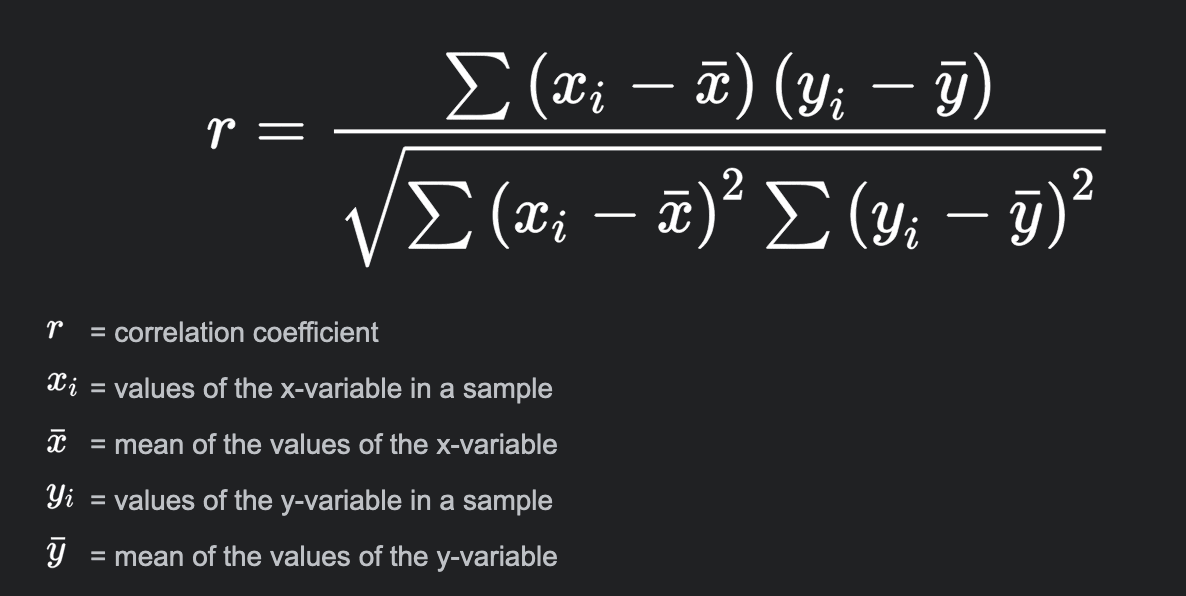

In [ ]:
class PearsonCorr(tf.keras.metrics.Metric):
    def __init__(self, name='pcorr', **kwargs):
        super(PearsonCorr, self).__init__(name=name, **kwargs)
        self.covar = self.add_weight(name="covar", initializer="zeros")
        self.x_mean = self.add_weight(name="x_mean", initializer="zeros")
        self.y_mean = self.add_weight(name="y_mean", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")
        self.x_var = self.add_weight(name="x_var", initializer="zeros")
        self.y_var = self.add_weight(name="y_var", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Flatten the arrays for multi-dimensional support
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1])

        # Update count, means, covariance, and variances
        self.count.assign_add(tf.cast(tf.size(y_true_flat), tf.float32))
        self.x_mean.assign_add(tf.reduce_mean(y_true_flat))
        self.y_mean.assign_add(tf.reduce_mean(y_pred_flat))
        self.covar.assign_add(tf.reduce_sum((y_true_flat - self.x_mean) * (y_pred_flat - self.y_mean)))
        self.x_var.assign_add(tf.reduce_sum(tf.square(y_true_flat - self.x_mean)))
        self.y_var.assign_add(tf.reduce_sum(tf.square(y_pred_flat - self.y_mean)))

    def result(self):
        covariance = self.covar / self.count
        std_x = tf.sqrt(self.x_var / self.count)
        std_y = tf.sqrt(self.y_var / self.count)
        return covariance / (std_x * std_y)

    def reset_state(self):
        self.covar.assign(0)
        self.x_mean.assign(0)
        self.y_mean.assign(0)
        self.count.assign(0)
        self.x_var.assign(0)
        self.y_var.assign(0)

def val_epoch(autoencoder, discriminator, val_dataset, total_its, batch_size):
    metrics = {
        "mse": tf.keras.metrics.MeanSquaredError(),
        "corr": PearsonCorr()
    }

    progress_bar = tqdm(range(total_its // batch_size + 1))

    for batch_ind, (hic, hms) in enumerate(val_dataset):
        hi_hic = autoencoder((hic, hms), training=False)

        for metric_name, metric in metrics.items():
            metric.update_state(y_true=hic, y_pred=hi_hic)

        progress_bar.update(1)

    computed = {metric_name: metric.result().numpy() for metric_name, metric in metrics.items()}
    return computed


In [ ]:
chpt_dir = f"./checkpoints/full_train"
autoencoder.load_weights(f"{chpt_dir}/autoencoder_weights.keras")

In [ ]:
for chr_num in [11, 17]:
  print(f"Testing on Chromosome {chr_num}")
  folder = f"{base_path}/{cell_line}/{hic_res}/chr{chr_num}"
  hic_sparse_mat_file = f"{folder}/hic_sparse_redone_h3k27ac_addition.npz"

  np_hmods_norm_all_file = f"{folder}/np_hmods_norm_chip_{chip_res}bp_redone_h3k27ac_addition.npy"

  mat = load_npz(hic_sparse_mat_file)

  allNodes_hms = np.load(np_hmods_norm_all_file)
  hms = allNodes_hms[:, 1:] #only includes features, not node ids
  hms = tf.convert_to_tensor(hms.reshape(-1, num_feat), dtype=tf.float32)

  num_bins = len(hms)
  total_its = 0
  for i in range(0, (num_bins // slice_len) -1):
    for j in range(i, (num_bins // slice_len) -1):
      total_its += 1

  def get_next_sample(slice_len):
    num_bins = len(hms)
    diag_ind = 0
    for i in range(0, (num_bins // slice_len) -1):
      hms_sub = hms[i*slice_len: (i+1) * slice_len]
      for j in range(i, (num_bins // slice_len) -1):
        hic_sub = mat[i*slice_len:(i+1)*slice_len, j*slice_len:(j+1)*slice_len].toarray()
        if hic_sub.shape != (slice_len, slice_len) or len(hms_sub) != slice_len:
          print(f"Slice Ranges: {i*slice_len},{(i+1)*slice_len}; {j*slice_len},{(j+1)*slice_len}")
          print(f"Data Shape Error on (i,j): ({i}, {j})")
          print(f" HiC Shape: {hic_sub.shape}\n Histone Mark Shape: {hms_sub.shape}")
        yield hic_sub, hms_sub

  slice_len = 256
  dataset = tf.data.Dataset.from_generator(
      get_next_sample,
      output_signature=(
          tf.TensorSpec(shape=(slice_len,slice_len), dtype=tf.float64),
          tf.TensorSpec(shape=(slice_len,num_feat), dtype=tf.float32)),
      args = [slice_len]
  )
  batch_size = 32
  chr_dataset = dataset.batch(batch_size).shuffle(dataset.cardinality())

  total_its = 0
  for i in range(0, (len(hms) // slice_len) -1):
    for j in range(i, (len(hms) // slice_len) -1):
      total_its += 1

  print(f"Evaluation stats: {val_epoch(autoencoder, discriminator, chr_dataset, total_its, batch_size)}")

## Importing CAESAR HiC Visualization

In [ ]:
## TAKEN FROM CAESAR!! https://github.com/liu-bioinfo-lab/caesar
import os
import numpy as np
# from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def visualize_HiC_epigenetics(HiC, epis, output, fig_width=12.0,
                              vmin=0, vmax=None, cmap='Reds', colorbar=True,
                              colorbar_orientation='vertical',
                              epi_labels=None, x_ticks=None, fontsize=24,
                              epi_colors=None, epi_yaxis=True,
                              heatmap_ratio=0.6, epi_ratio=0.1,
                              interval_after_heatmap=0.05, interval_between_epi=0.01, ):
    """
    Visualize matched HiC and epigenetic signals in one figure
    Args:
        HiC (numpy.array): Hi-C contact map, only upper triangle is used.
        epis (list): epigenetic signals
        output (str): the output path. Must in a proper format (e.g., 'png', 'pdf', 'svg', ...).
        fig_width (float): the width of the figure. Then the height will be automatically calculated. Default: 12.0
        vmin (float): min value of the colormap. Default: 0
        vmax (float): max value of the colormap. Will use the max value in Hi-C data if not specified.
        cmap (str or plt.cm): which colormap to use. Default: 'Reds'
        colorbar (bool): whether to add colorbar for the heatmap. Default: True
        colorbar_orientation (str): "horizontal" or "vertical". Default: "vertical"
        epi_labels (list): the names of epigenetic marks. If None, there will be no labels at y axis.
        x_ticks (list): a list of strings. Will be added at the bottom. THE FIRST TICK WILL BE AT THE START OF THE SIGNAL, THE LAST TICK WILL BE AT THE END.
        fontsize (int): font size. Default: 24
        epi_colors (list): colors of epigenetic signals
        epi_yaxis (bool): whether add y-axis to epigenetic signals. Default: True
        heatmap_ratio (float): the ratio of (heatmap height) and (figure width). Default: 0.6
        epi_ratio (float): the ratio of (1D epi signal height) and (figure width). Default: 0.1
        interval_after_heatmap (float): the ratio of (interval between heatmap and 1D signals) and (figure width). Default: 0.05
        interval_between_epi (float): the ratio of (interval between 1D signals) and (figure width). Default: 0.01

    No return. Save a figure only.
    """

    # Make sure the lengths match
    # len_epis = [len(epi) for epi in epis]
    # if max(len_epis) != min(len_epis) or max(len_epis) != len(HiC):
    #     raise ValueError('Size not matched!')
    N = len(HiC)

    # Define the space for each row (heatmap - interval - signal - interval - signal ...)
    rs = [heatmap_ratio, interval_after_heatmap] + [epi_ratio, interval_between_epi] * len(epis)
    rs = np.array(rs[:-1])

    # Calculate figure height
    fig_height = fig_width * np.sum(rs)
    rs = rs / np.sum(rs)  # normalize to 1 (ratios)
    fig = plt.figure(figsize=(fig_width, fig_height))

    # Split the figure into rows with different heights
    gs = GridSpec(len(rs), 1, height_ratios=rs)

    # Ready for plotting heatmap
    ax0 = plt.subplot(gs[0, :])
    # Define the rotated axes and coordinates
    coordinate = np.array([[[(x + y) / 2, y - x] for y in range(N + 1)] for x in range(N + 1)])
    X, Y = coordinate[:, :, 0], coordinate[:, :, 1]
    # Plot the heatmap
    vmax = vmax if vmax is not None else np.max(HiC)
    im = ax0.pcolormesh(X, Y, HiC, vmin=vmin, vmax=vmax, cmap=cmap)
    ax0.axis('off')
    ax0.set_ylim([0, N])
    ax0.set_xlim([0, N])
    if colorbar:
        if colorbar_orientation == 'horizontal':
            _left, _width, _bottom, _height = 0.12, 0.25, 1 - rs[0] * 0.25, rs[0] * 0.03
        elif colorbar_orientation == 'vertical':
            _left, _width, _bottom, _height = 0.9, 0.02, 1 - rs[0] * 0.7, rs[0] * 0.5
        else:
            raise ValueError('Wrong orientation!')
        cbar = plt.colorbar(im, cax=fig.add_axes([_left, _bottom, _width, _height]),
                            orientation=colorbar_orientation)
        cbar.ax.tick_params(labelsize=fontsize)
        cbar.outline.set_visible(False)

    # print(rs/np.sum(rs))
    # Ready for plotting 1D signals
    if epi_labels:
        assert len(epis) == len(epi_labels)
    if epi_colors:
        assert len(epis) == len(epi_colors)

    for i, epi in enumerate(epis):
        # print(epi.shape)
        ax1 = plt.subplot(gs[2 + 2 * i, :])

        if epi_colors:
            ax1.fill_between(np.arange(N), 0, epi, color=epi_colors[i])
        else:
            ax1.fill_between(np.arange(N), 0, epi)
        ax1.spines['left'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)

        if not epi_yaxis:
            ax1.set_yticks([])
            ax1.set_yticklabels([])
        else:
            ax1.spines['right'].set_visible(True)
            ax1.tick_params(labelsize=fontsize)
            ax1.yaxis.tick_right()

        if i != len(epis) - 1:
            ax1.set_xticks([])
            ax1.set_xticklabels([])
        # ax1.axis('off')
        # ax1.xaxis.set_visible(True)
        # plt.setp(ax1.spines.values(), visible=False)
        # ax1.yaxis.set_visible(True)

        ax1.set_xlim([-0.5, N - 0.5])
        if epi_labels:
            ax1.set_ylabel(epi_labels[i], fontsize=fontsize, rotation=0)
    ax1.spines['bottom'].set_visible(True)
    if x_ticks:
        tick_pos = np.linspace(0, N - 1, len(x_ticks))  # 这个坐标其实是不对的 差1个bin 但是为了ticks好看只有先这样了
        ax1.set_xticks(tick_pos)
        ax1.set_xticklabels(x_ticks, fontsize=fontsize)
    else:
        ax1.set_xticks([])
        ax1.set_xticklabels([])

    plt.savefig(output)
    plt.close()

## Predict HiC

In [ ]:
chr_num = 17
print(f"Testing on Chromosome {chr_num}")
folder = f"{base_path}/{cell_line}/{hic_res}/chr{chr_num}"
hic_sparse_mat_file = f"{folder}/hic_sparse_redone_h3k27ac_addition.npz"

np_hmods_norm_all_file = f"{folder}/np_hmods_norm_chip_{chip_res}bp_redone_h3k27ac_addition.npy"

mat = load_npz(hic_sparse_mat_file)

allNodes_hms = np.load(np_hmods_norm_all_file)
hms = allNodes_hms[:, 1:] #only includes features, not node ids
hms = tf.convert_to_tensor(hms.reshape(-1, num_feat), dtype=tf.float32)

pred_hic = np.zeros(shape = mat.shape)

slice_len = 256
num_bins = len(hms)
diag_ind = 0
for i in range(0, (num_bins // slice_len) + 1):
  if (i+1) * slice_len > num_bins: i = num_bins - slice_len
  hms_sub = np.expand_dims(hms[i*slice_len: (i+1) * slice_len].numpy(), axis=0)
  for j in range((num_bins // slice_len) + 1):
    if (j+1) * slice_len > num_bins: j = num_bins - slice_len
    hic_sub = np.expand_dims(mat[i*slice_len:(i+1)*slice_len, j*slice_len:(j+1)*slice_len].toarray(), axis=0)
    hi_hic = autoencoder((hic_sub, hms_sub), training=False)
    pred_hic[i*slice_len:(i+1)*slice_len, j*slice_len:(j+1)*slice_len] = np.squeeze(hi_hic.numpy())


visualize_HiC_epigenetics(pred_hic, tf.transpose(hms), f"./{cell_line}/pred_chr{chr_num}_hic_vis.png",
                          colorbar=True, interval_after_heatmap=0.,
                          interval_between_epi=0., epi_labels=["H3K27me3", "H3K36me3", "H3K4me1", "H3K4me3", "H3K9me3"],
                          epi_yaxis=True, fontsize=20, epi_ratio=0.045,
                          x_ticks=['', '', '', '', '', ''], vmax=np.quantile(pred_hic, 0.98))

In [ ]:
chr_num = 17
print(f"Testing on Chromosome {chr_num}")
folder = f"{base_path}/{cell_line}/{hic_res}/chr{chr_num}"
hic_sparse_mat_file = f"{folder}/hic_sparse_redone_h3k27ac_addition.npz"

np_hmods_norm_all_file = f"{folder}/np_hmods_norm_chip_{chip_res}bp_redone_h3k27ac_addition.npy"

mat = load_npz(hic_sparse_mat_file)

hms = np.load(np_hmods_norm_all_file)
hms = hms[:, 1:] #only includes features, not node ids
hms = tf.convert_to_tensor(hms.reshape(-1, num_feat), dtype=tf.float32)

visualize_HiC_epigenetics(mat.toarray(), tf.transpose(hms), f"./{cell_line}/ground_truth_chr{chr_num}_hic_vis.png",
                          colorbar=True, interval_after_heatmap=0.,
                          interval_between_epi=0., epi_labels=["H3K27me3", "H3K36me3", "H3K4me1", "H3K4me3", "H3K9me3"],
                          epi_yaxis=True, fontsize=20, epi_ratio=0.045,
                          x_ticks=['', '', '', '', '', ''], vmax=np.quantile(mat.toarray(), 0.98))